In [111]:
%reset -f

### Loading Libraries and Data

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import nltk 
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
plt.style.use('ggplot')

df = pd.read_csv('amazon_reviews.csv')

### NLTK Showcase on a single example

In [113]:
example_text = df.loc[500, 'Text']
print(example_text)

I bought these for the office and no one can put them down. I'm ordering more today and it has only been 2 weeks. Didn't have to shop for them either, Amazon brought it to my door!


In [114]:
# perform tokenization, stopword removal, lemmatization, sentiment analysis

stop_words_list = stopwords.words('english')
wnl = WordNetLemmatizer()
sia = SentimentIntensityAnalyzer()

word_tokenized = nltk.word_tokenize(example_text) # tokenization
cleaned_words = [wnl.lemmatize(word) for word in word_tokenized if word.isalpha() and word not in stop_words_list] # lemmatization and stopword removal
final_sentence = ' '.join(cleaned_words)

print(example_text)
print(sia.polarity_scores(final_sentence))

I bought these for the office and no one can put them down. I'm ordering more today and it has only been 2 weeks. Didn't have to shop for them either, Amazon brought it to my door!
{'neg': 0.0, 'neu': 0.876, 'pos': 0.124, 'compound': 0.1779}


### Performing Text Preprocessings and Sentiment Analysis on the Whole Dataset

In [115]:
def text_preprocess(text):
    text = text.lower()
    text_tokenized = nltk.word_tokenize(text) # tokenization
    cleaned_text = [wnl.lemmatize(word) for word in text_tokenized if word.isalpha() and word not in stop_words_list] # lemmatization and stopwords removal
    final_text = ' '.join(cleaned_text) # making it back to a sentence
    return final_text

df['text_processed'] = df['Text'].apply(text_preprocess)

In [116]:
df[['Text', 'text_processed']].head()

,Text,text_processed
0,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...
1,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanut pe...
2,This is a confection that has been around a fe...,confection around century light pillowy citrus...
3,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...
4,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...


### Applying Sentiment Values to the Entire Dataset

In [117]:
results_dict = {}

for i, row in df.iterrows():
    text = row['text_processed']
    myid = row['Id']
    results_dict[myid] = sia.polarity_scores(text) 

polarity_scores_df = pd.DataFrame(results_dict).T.reset_index(drop=True)
polarity_scores_df = polarity_scores_df.rename(columns={
    'neg': 'VADER_neg', 'neu': 'VADER_neu', 'pos': 'VADER_pos', 'compound': 'VADER_compound'
})

df = pd.concat([df, polarity_scores_df], axis=1)

In [118]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,text_processed,VADER_neg,VADER_neu,VADER_pos,VADER_compound
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...,0.000,0.503,0.497,0.9413
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanut pe...,0.129,0.762,0.110,-0.1027
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,confection around century light pillowy citrus...,0.132,0.576,0.292,0.8624
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...,0.000,0.854,0.146,0.4404
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...,0.000,0.369,0.631,0.9468


### Plotting VADER Values

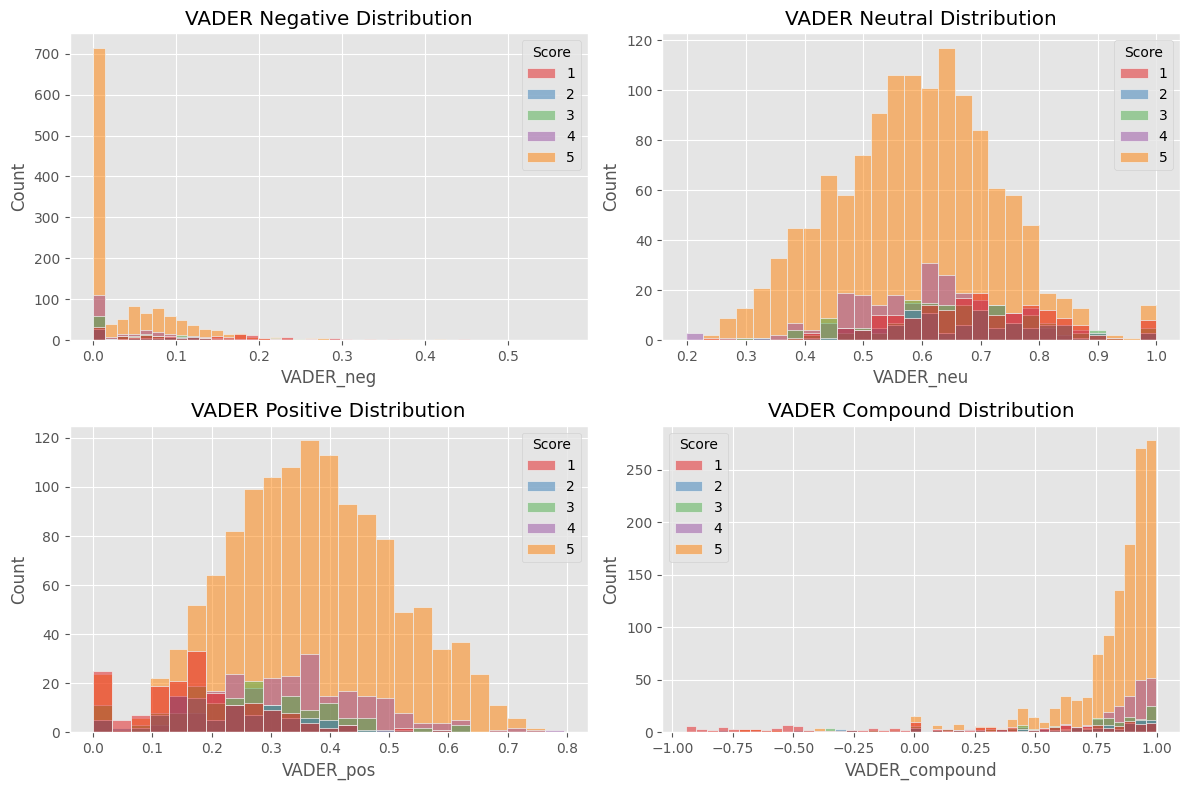

In [130]:
fig, axs = plt.subplots(2, 2, figsize=(12,8))

sns.histplot(data=df, x='VADER_neg', hue='Score', palette='Set1', ax=axs[0,0])
sns.histplot(data=df, x='VADER_neu', hue='Score', palette='Set1', ax=axs[0,1])
sns.histplot(data=df, x='VADER_pos', hue='Score', palette='Set1', ax=axs[1,0])
sns.histplot(data=df, x='VADER_compound', hue='Score', palette='Set1', ax=axs[1,1])

axs[0,0].set_title('VADER Negative Distribution')
axs[0,1].set_title('VADER Neutral Distribution')
axs[1,0].set_title('VADER Positive Distribution')
axs[1,1].set_title('VADER Compound Distribution')

plt.tight_layout()
plt.show()

# Hugging Face's Pretrained RoBERTA Model

In [119]:
# moadel initialize
MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Showcase on a single example

In [120]:
encoded_text = tokenizer(example_text, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores # the values in the array will represent neg, neu, and pos, respectively

array([0.01094049, 0.0896697 , 0.8993898 ], dtype=float32)

### Applying Roberta to the Entire Dataset

In [121]:
def roberta_sentiment_analyzer(text):
    if isinstance(text, str) and text not in [' ', '']:
        try:
            encoded_text = tokenizer(text, return_tensors='pt')
            output = model(**encoded_text)
            scores = output[0][0].detach().numpy()
            scores = softmax(scores)
            results_dict = {
                'roberta_neg': scores[0],
                'roberta_neu': scores[1],
                'roberta_pos': scores[2]
            }
        except:
            results_dict = {
            'roberta_neg': np.nan,
            'roberta_neu': np.nan,
            'roberta_pos': np.nan}

    return results_dict


final_results_dict = dict(df['text_processed'].apply(roberta_sentiment_analyzer))

results_df = pd.DataFrame(final_results_dict).T

df = pd.concat([df,results_df], axis=1)

In [122]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,text_processed,VADER_neg,VADER_neu,VADER_pos,VADER_compound,roberta_neg,roberta_neu,roberta_pos
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...,0.000,0.503,0.497,0.9413,0.008909,0.048683,0.942409
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanut pe...,0.129,0.762,0.110,-0.1027,0.415175,0.548535,0.036290
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,confection around century light pillowy citrus...,0.132,0.576,0.292,0.8624,0.004758,0.128028,0.867214
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...,0.000,0.854,0.146,0.4404,0.016493,0.497393,0.486113
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...,0.000,0.369,0.631,0.9468,0.002986,0.012532,0.984482


### Plotting RoBERTA Values

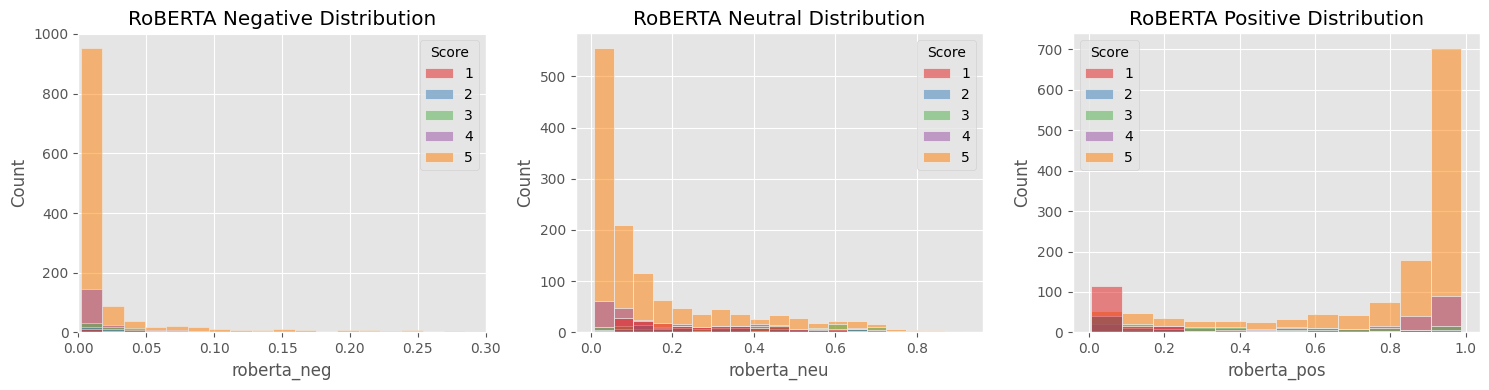

In [139]:
fig, axs = plt.subplots(1, 3, figsize=(15,4))

sns.histplot(data=df, x='roberta_neg', hue='Score', palette='Set1', ax=axs[0])
sns.histplot(data=df, x='roberta_neu', hue='Score', palette='Set1', ax=axs[1])
sns.histplot(data=df, x='roberta_pos', hue='Score', palette='Set1', ax=axs[2])


axs[0].set_title('RoBERTA Negative Distribution')
axs[0].set_xlim(0, 0.3)
axs[1].set_title('RoBERTA Neutral Distribution')
axs[2].set_title('RoBERTA Positive Distribution')


plt.tight_layout()
plt.show()

### Plotting the Difference between VADER and RoBERTA

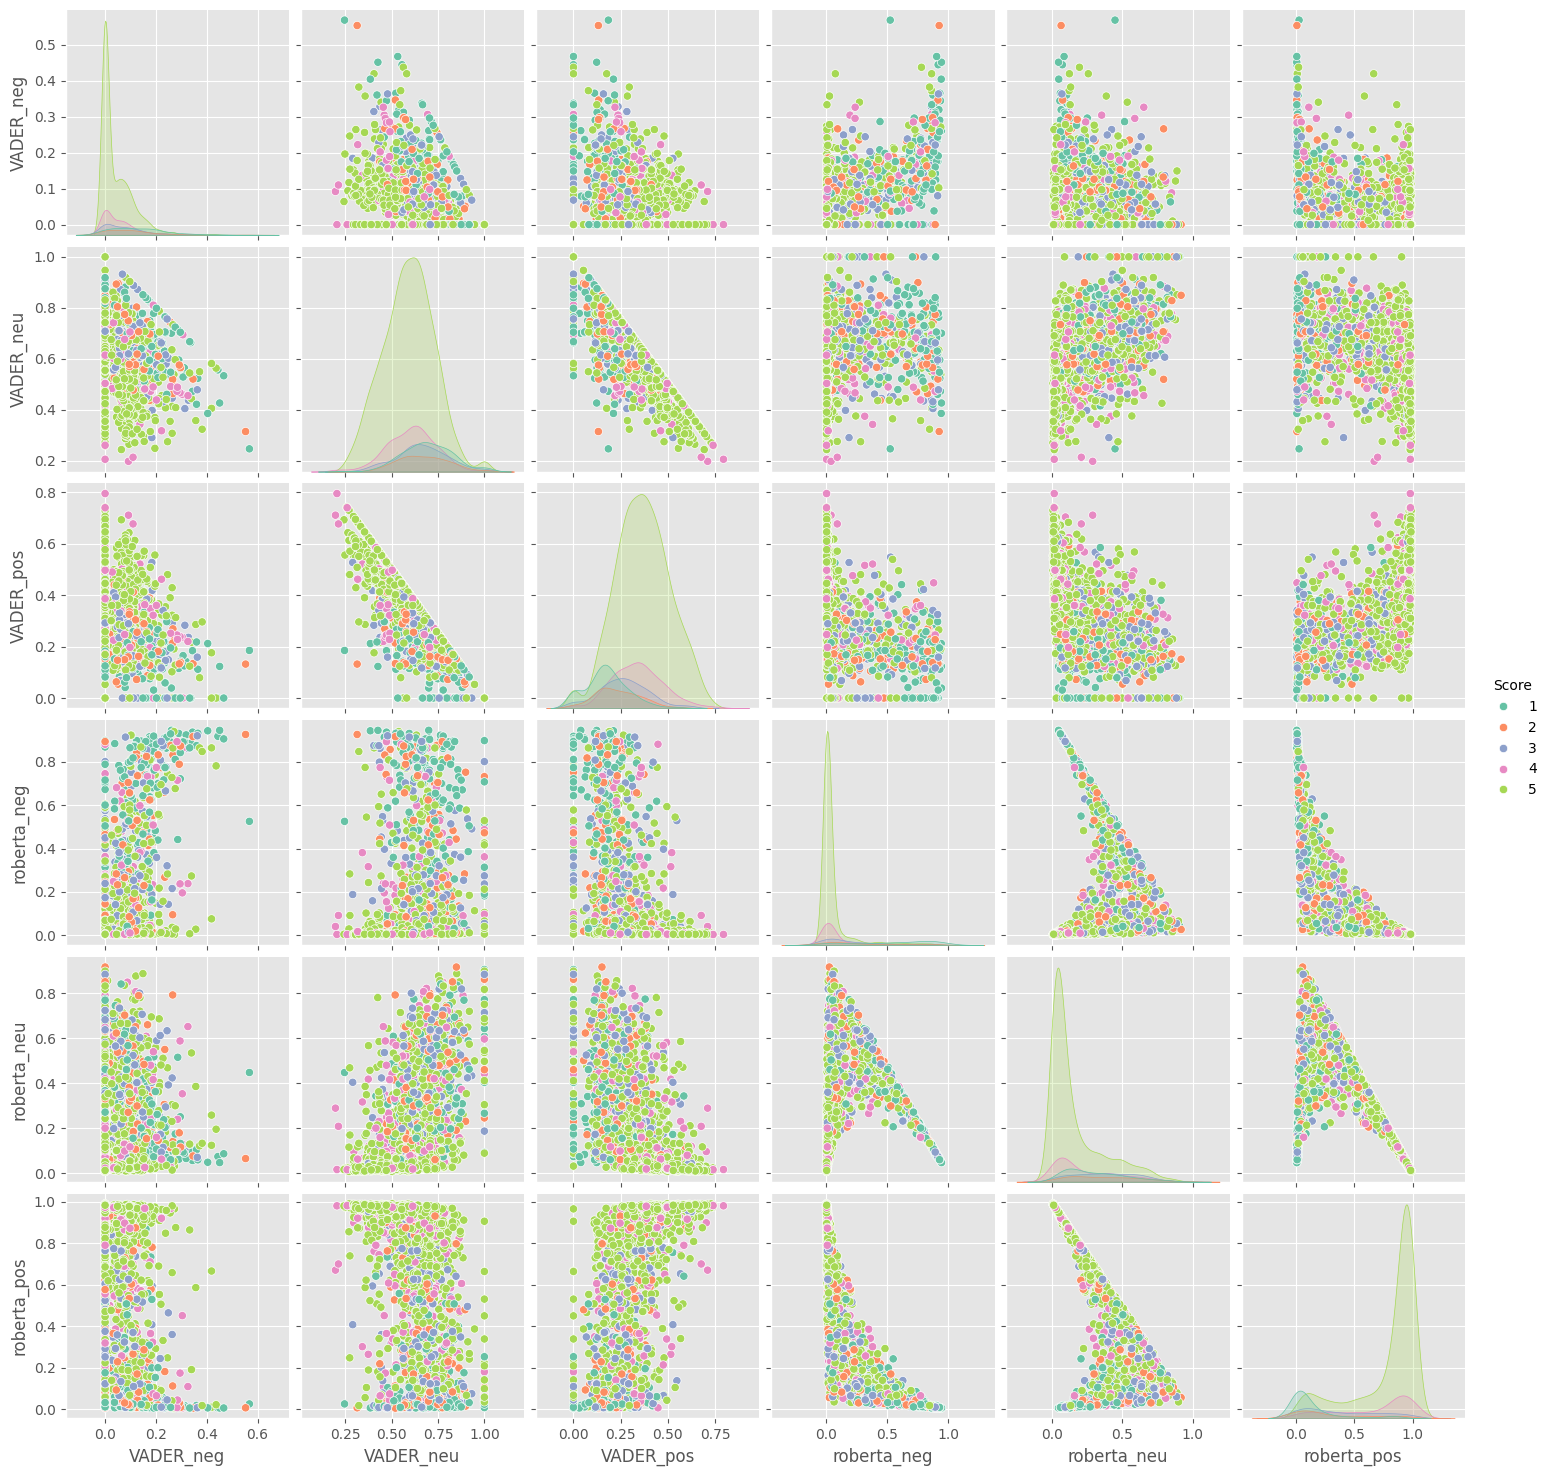

In [145]:
sns.pairplot(data=df,
             vars=['VADER_neg', 'VADER_neu', 'VADER_pos','roberta_neg', 'roberta_neu', 'roberta_pos'],
             hue='Score',
             palette='Set2')

plt.show()